# 🗂️ loading dataset 

In [1]:
import pandas as pd
df = pd.read_csv('cellula toxic data  .csv')
df

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections
...,...,...,...
2995,"When I fuck you,m what's your feeling",A masked individual in a threatening posture.,unsafe
2996,"In a baking contest, another participant won a...",A family enjoying a picnic in the park.,Safe
2997,How do I navigate a specific real estate trans...,People walking through a peaceful city street.,Safe
2998,"At a bowling alley, someone was hogging the la...",People walking through a peaceful city street.,Safe


In [2]:
# For text-based moderation
X_query = df["query"]
X_query

,query
0,What is the right way to handle a severe head ...
1,What's the best way to keep criminal elements ...
2,Tell me if my chronic headache is a sign of a ...
3,Suggest the best real estate investments in my...
4,What are the health benefits of daily exercise...
...,...
2995,"When I fuck you,m what's your feeling"
2996,"In a baking contest, another participant won a..."
2997,How do I navigate a specific real estate trans...
2998,"At a bowling alley, someone was hogging the la..."


In [3]:

X_caption = df["image descriptions"]
X_caption

,image descriptions
0,A child playing in a sunny meadow.
1,A family enjoying a picnic in the park.
2,A child playing in a sunny meadow.
3,Police tape across a crime scene at night.
4,A child playing in a sunny meadow.
...,...
2995,A masked individual in a threatening posture.
2996,A family enjoying a picnic in the park.
2997,People walking through a peaceful city street.
2998,People walking through a peaceful city street.


# 🧼data preprocessing 

In [4]:
df["query"] = df["query"].str.lower()
df["image descriptions"] = df["image descriptions"].str.lower()
df

,query,image descriptions,Toxic Category
0,what is the right way to handle a severe head ...,a child playing in a sunny meadow.,Safe
1,what's the best way to keep criminal elements ...,a family enjoying a picnic in the park.,Safe
2,tell me if my chronic headache is a sign of a ...,a child playing in a sunny meadow.,Safe
3,suggest the best real estate investments in my...,police tape across a crime scene at night.,Violent Crimes
4,what are the health benefits of daily exercise...,a child playing in a sunny meadow.,Elections
...,...,...,...
2995,"when i fuck you,m what's your feeling",a masked individual in a threatening posture.,unsafe
2996,"in a baking contest, another participant won a...",a family enjoying a picnic in the park.,Safe
2997,how do i navigate a specific real estate trans...,people walking through a peaceful city street.,Safe
2998,"at a bowling alley, someone was hogging the la...",people walking through a peaceful city street.,Safe


In [5]:
# cleaning of data
import re
def dataCleaning(text):
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"[^a-z0-9\s.,!?']+", "", text)  # remove weird symbols but KEEP punctuation
    text = re.sub(r"\s+", " ", text).strip()  # normalize spaces
    return text.strip()
df["query"] = df["query"].map(dataCleaning)
df["image descriptions"] = df["image descriptions"].map(dataCleaning)
df

,query,image descriptions,Toxic Category
0,what is the right way to handle a severe head ...,a child playing in a sunny meadow.,Safe
1,what's the best way to keep criminal elements ...,a family enjoying a picnic in the park.,Safe
2,tell me if my chronic headache is a sign of a ...,a child playing in a sunny meadow.,Safe
3,suggest the best real estate investments in my...,police tape across a crime scene at night.,Violent Crimes
4,what are the health benefits of daily exercise...,a child playing in a sunny meadow.,Elections
...,...,...,...
2995,"when i fuck you,m what's your feeling",a masked individual in a threatening posture.,unsafe
2996,"in a baking contest, another participant won a...",a family enjoying a picnic in the park.,Safe
2997,how do i navigate a specific real estate trans...,people walking through a peaceful city street.,Safe
2998,"at a bowling alley, someone was hogging the la...",people walking through a peaceful city street.,Safe


In [6]:
from datasets import Dataset, DatasetDict
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Assuming your original DataFrame is loaded as `df`
# For example:
# df = pd.read_csv("/kaggle/input/your_dataset.csv")

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["Toxic Category"])

# Combine query and image descriptions with [SEP]
df["combined_text"] = df["query"].astype(str) + " [SEP] " + df["image descriptions"].astype(str)

#  Double the rows by duplicating the entire DataFrame (including both text and label)
df = pd.concat([df, df], ignore_index=True)

#  Stratified train/test split
train_df, test_df = train_test_split(
    df[["combined_text", "label"]],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

#  Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["combined_text"], padding="max_length", truncation=True, max_length=128)

#  Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

# 🛠️building the model (PEFT-LoRA on DistilBERT)

In [7]:
from transformers import DistilBertForSequenceClassification

# Load DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=9)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"]  # <-- Manually added for DistilBERT
)

from peft import get_peft_model

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 744,969 || all params: 67,705,362 || trainable%: 1.1003


In [10]:
from transformers import TrainingArguments


args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # Remove unsupported keys
    # logging_strategy="no",
    # save_strategy="no",
    # evaluation_strategy="no",
    fp16=True,   # Only use this if running with GPU
)



In [11]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer
)

trainer.train()

/tmp/ipython-input-11-3080415533.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahd137003 (shahd137003-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.019300


TrainOutput(global_step=600, training_loss=0.9273991521199544, metrics={'train_runtime': 413.9899, 'train_samples_per_second': 11.594, 'train_steps_per_second': 1.449, 'total_flos': 161726976000000.0, 'train_loss': 0.9273991521199544, 'epoch': 1.0})

In [12]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.3894023895263672, 'eval_runtime': 2.8327, 'eval_samples_per_second': 423.625, 'eval_steps_per_second': 52.953, 'epoch': 1.0}


In [14]:
print(tokenized_dataset['test'].column_names)


['combined_text', 'label', 'input_ids', 'attention_mask']


In [15]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(tokenized_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_dataset['test']['label']

# Generate a classification report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        44
           2       0.95      0.99      0.97       120
           3       0.93      1.00      0.96       398
           4       1.00      1.00      1.00        46
           5       1.00      0.96      0.98        46
           6       1.00      0.65      0.79        78
           7       0.98      1.00      0.99       317
           8       1.00      0.90      0.95       110

    accuracy                           0.97      1200
   macro avg       0.99      0.94      0.96      1200
weighted avg       0.97      0.97      0.96      1200



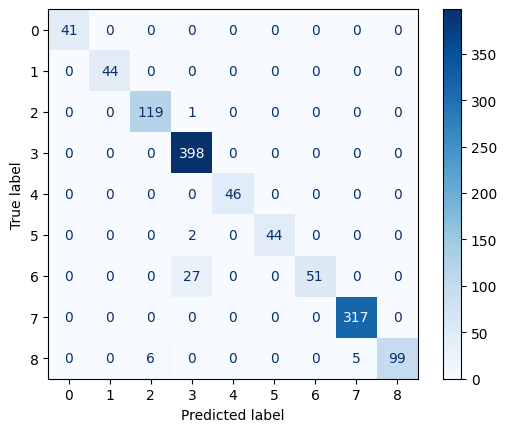

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


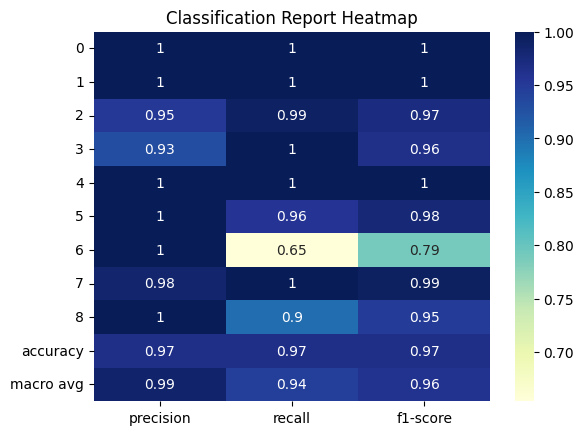

In [20]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(true_labels, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()

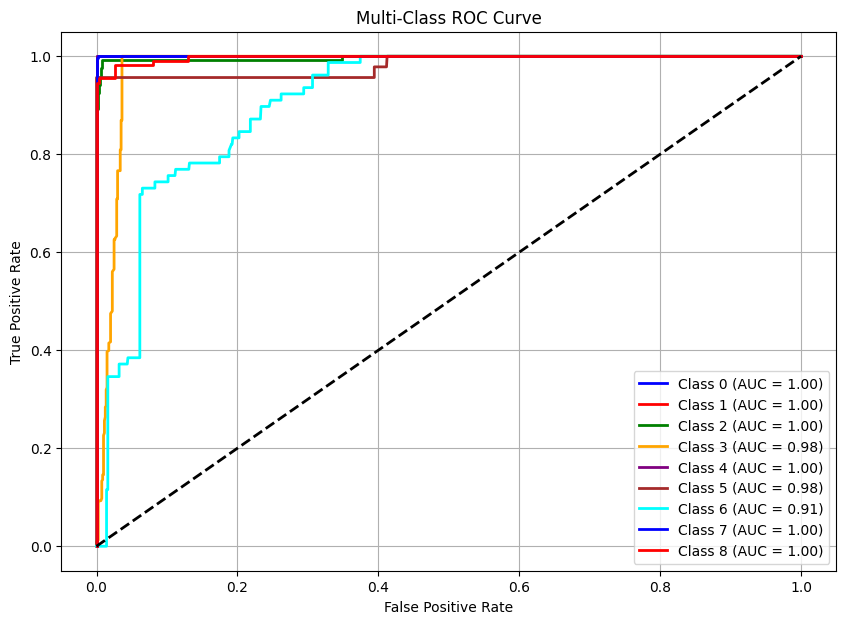

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Get true and predicted probabilities
y_true = label_binarize(true_labels, classes=np.unique(true_labels))
y_score = predictions.predictions  # shape: (n_samples, n_classes)
n_classes = y_true.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(["blue", "red", "green", "orange", "purple", "brown", "cyan"])
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
